По базе машин с ЮЛЫ данным обучите модель для предсказания цен на машины.

1. Создайте обучающую, тестовую и проверочную выборки. 

2. Оцените качество работы созданной сети, определив средний процент ошибки на проверочной выборке. (Для этого потребуется привести предсказанные моделью значения к первоначальному диапазону цен.)  

3. Подсчитайте ошибку на каждом примере тестовой выборки и суммарный процент ошибки.


Рекомендации:
- в качестве ошибки рекомендуется использовать среднеквадратическую ошибку (mse).
- метрику для данной задачи можно не использовать.
- последний слой модели должен иметь 1 нейрон.
- суммарный процент ошибки = средний модуль ошибки (MAE) / среднюю цену машины. Например, если средняя цена машины 560.000 р, а средняя ошибка 56.000р, то процент ошибки равен 10%.


In [ ]:
import numpy as np  # Работа с массивами данных
import pandas as pd # Работа с табличными данными

from tensorflow.keras import utils                     # Функции-утилиты для работы с категориальными данными
from tensorflow.keras.models import Sequential, Model  # Класс для конструирования последовательной модели нейронной сети

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop # Оптимизаторы
# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler      # Масштабирование данных

import gdown                    # Загрузка датасетов из облака google
import re                       # Регулярные выражения
import matplotlib.pyplot as plt # Отрисовка графиков

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

## Upload data

In [ ]:
gdown.download('https://storage.googleapis.com/datasets_ai/Base/10_regression/cars_new.csv', None, quiet=True)

'cars_new.csv'

In [ ]:
auto_data = pd.read_csv('cars_new.csv')

In [ ]:
auto_data.head()

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [ ]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70119 entries, 0 to 70118
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   mark     70119 non-null  object 
 1   model    70119 non-null  object 
 2   price    70119 non-null  int64  
 3   year     70119 non-null  int64  
 4   mileage  70119 non-null  int64  
 5   body     70116 non-null  object 
 6   kpp      70115 non-null  object 
 7   fuel     70119 non-null  object 
 8   volume   70119 non-null  float64
 9   power    70119 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 5.3+ MB


In [ ]:
auto_data.describe()

,price,year,mileage,volume,power
count,7.011900e+04,70119.000000,70119.000000,70119.000000,70119.000000
mean,5.277261e+05,2007.228668,162237.510988,1.917526,136.473381
std,6.236842e+05,7.086385,95872.148255,0.671154,59.054250
min,1.600000e+04,1949.000000,1.000000,0.300000,11.000000
25%,2.050000e+05,2004.000000,96980.000000,1.600000,102.000000
50%,3.800000e+05,2008.000000,147000.000000,1.800000,123.000000
75%,6.400000e+05,2012.000000,210000.000000,2.000000,152.000000
max,2.450000e+07,2019.000000,999999.000000,10.000000,1400.000000


In [ ]:
str_columns = auto_data.select_dtypes(include=[object]).columns.to_list()
str_columns

['mark', 'model', 'body', 'kpp', 'fuel']

In [ ]:
for column in str_columns:
    print(f'Column name: {column}')
    print(auto_data[column].value_counts())
    print()

Column name: mark
toyota           4043
mercedes-benz    4032
ford             4031
opel             4023
mitsubishi       4023
bmw              4019
chevrolet        3999
volkswagen       3997
nissan           3988
hyundai          3975
kia              3957
renault          3931
audi             3781
mazda            3770
daewoo           3260
skoda            2931
honda            2528
peugeot          2167
suzuki           1320
chery            1206
subaru           1138
Name: mark, dtype: int64

Column name: model
matiz m150 [рестайлинг]               1062
focus 3 поколение                      827
nexia 1 поколение [2-й рестайлинг]     811
nexia 1 поколение [рестайлинг]         732
lacetti 1 поколение                    625
                                      ... 
i40                                      1
fto 1 поколение                          1
jetta 3 поколение                        1
aristo s14 [рестайлинг]                  1
x3 f25                                   1
Na

## Preprocess the data

In [ ]:
# change minor auto types to similar classes
auto_data.loc[auto_data.body.isin(
          ['тарга', 'фастбэк', 'родстер', 'хардтоп']), 'body'] = 'кабриолет'
auto_data.loc[auto_data.body.isin(
          ['микроавтобус']), 'body'] = 'минивэн'
auto_data.loc[auto_data.body.isin(
          ['лифтбэк']), 'body'] = 'хетчбэк'

In [ ]:
# get rid of outliers
upper_limit = auto_data.mileage.quantile(0.99)
auto_data.loc[auto_data.mileage > upper_limit, 'mileage'] = upper_limit

upper_limit = auto_data.power.quantile(0.99)
auto_data.loc[auto_data.power > upper_limit, 'power'] = upper_limit

upper_limit = auto_data.volume.quantile(0.99)
auto_data.loc[auto_data.volume > upper_limit, 'volume'] = upper_limit

In [ ]:
# Преобразование model в числовые/векторные для обучения нейросетью

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=800, # объем словаря
                      filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', # убираемые из текста ненужные символы 
                      lower=True, # приведение слов к нижнему регистру
                      split=' ', # разделитель слов
                      oov_token='unknown', # указание разделять по словам, а не по единичным символам
                      char_level=False # токен для слов, которые не вошли в словарь
                      )

# Построение частотного словаря по текстам профессий
tokenizer.fit_on_texts(auto_data['model']) 

items = list(tokenizer.word_index.items())       # Получение индексов слов
print(items[:50])                                # Посмотр 50 самых часто встречающихся слов
print("Размер словаря", len(items))              # Длина словаря

[('unknown', 1), ('поколение', 2), ('рестайлинг', 3), ('1', 4), ('2', 5), ('3', 6), ('класс', 7), ('5', 8), ('серия', 9), ('focus', 10), ('astra', 11), ('nexia', 12), ('й', 13), ('4', 14), ('6', 15), ('octavia', 16), ('rio', 17), ('e', 18), ('lancer', 19), ('solaris', 20), ('logan', 21), ('h', 22), ('matiz', 23), ('passat', 24), ('7', 25), ('m150', 26), ('c', 27), ('niva', 28), ('family', 29), ('a6', 30), ('x', 31), ('a4', 32), ('200', 33), ('polo', 34), ('pajero', 35), ('cx', 36), ('cruze', 37), ('grand', 38), ('j300', 39), ('ix', 40), ('sportage', 41), ('s', 42), ('lacetti', 43), ('corolla', 44), ('duster', 45), ('x5', 46), ('outlander', 47), ('a', 48), ('308', 49), ('b3', 50)]
Размер словаря 1454


In [ ]:
# Преобразование текстов в последовательность индексов согласно частотному словарю
exp_seq = tokenizer.texts_to_sequences(auto_data['model'])
# Преобразование последовательностей индексов в bag of words
model_processed = tokenizer.sequences_to_matrix(exp_seq)

In [ ]:
# Проверка результата
print(model_processed.shape)
print(model_processed[0][0:100])

(70119, 800)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
# Remove models from initil dataframe
str_columns.remove('model')
del auto_data['model']

## Data standartization

In [ ]:
# choose only numerical columns
list2scale = list(set(auto_data.columns) - set(str_columns) - set(['price']))

In [ ]:
list2scale

['mileage', 'year', 'power', 'volume']

In [ ]:
# apply standartization
trans = MinMaxScaler()
auto_data[list2scale] = trans.fit_transform(auto_data[list2scale])

In [ ]:
auto_data.head()

,mark,price,year,mileage,body,kpp,fuel,volume,power
0,kia,996000,0.985714,0.062220,седан,автомат,бензин,0.175258,0.100072
1,daewoo,140200,0.900000,0.134443,седан,механика,бензин,0.123711,0.049676
2,suzuki,750000,0.885714,0.064442,внедорожник,автомат,бензин,0.103093,0.053276
3,bmw,970000,0.928571,0.109998,кроссовер,автомат,бензин,0.175258,0.100072
4,chevrolet,205000,0.828571,0.336543,седан,механика,бензин,0.113402,0.060475


### Split on train and test df

In [ ]:
# get answers as separate variable
y = np.array(auto_data['price']/1000)
del auto_data['price']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(auto_data,
                                                    y,
                                                    test_size=0.2)

#split the data about automotive models
model_processed_train = model_processed[X_train.index]
model_processed_test = model_processed[X_test.index]

### One hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[str_columns]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_test[str_columns]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(str_columns, axis=1)
num_X_valid = X_test.drop(str_columns, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
print(OH_X_train)

           year   mileage    volume     power    0  ...   37   38   39   40   41
42277  0.942857  0.162220  0.134021  0.080634  0.0  ...  1.0  0.0  0.0  0.0  0.0
2683   0.842857  0.433332  0.134021  0.069114  0.0  ...  1.0  0.0  0.0  0.0  0.0
66745  0.871429  0.284443  0.134021  0.084233  0.0  ...  0.0  0.0  0.0  1.0  0.0
45893  0.742857  0.593332  0.278351  0.133909  0.0  ...  1.0  0.0  0.0  0.0  0.0
39132  0.842857  0.399999  0.154639  0.095032  0.0  ...  1.0  0.0  0.0  0.0  0.0
...         ...       ...       ...       ...  ...  ...  ...  ...  ...  ...  ...
32864  0.900000  0.267934  0.092784  0.067675  1.0  ...  1.0  0.0  0.0  0.0  0.0
44243  0.757143  0.659999  0.154639  0.100072  0.0  ...  1.0  0.0  0.0  0.0  0.0
67182  0.914286  0.298887  0.134021  0.080634  0.0  ...  1.0  0.0  0.0  0.0  0.0
6056   0.914286  0.191109  0.154639  0.092873  0.0  ...  1.0  0.0  0.0  0.0  0.0
56239  0.542857  0.288887  0.154639  0.072714  1.0  ...  1.0  0.0  0.0  0.0  0.0

[56095 rows x 46 columns]


## Models

Result evaluation functions

In [ ]:
def plot_history(history):
    plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Функция оценки результатов и вывода оценки
def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f} Предсказанное значение: {:6.2f} Разница: {:6.2f}'.format(y_train[i],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()      

## First model with two chanels. Process separately data about model's and other

In [ ]:
input1 = Input((OH_X_train.shape[1],))
input2 = Input((model_processed_train.shape[1],))

x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(25, activation="relu")(x2)
x2 = Dense(750, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение трех веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_final = Model((input1, input2), x)

Epoch 1/100
187/187 [==============================] - 4s 21ms/step - loss: 379308.3750 - mae: 331.3677 - val_loss: 191302.7969 - val_mae: 158.6962
Epoch 2/100
187/187 [==============================] - 4s 20ms/step - loss: 171970.9062 - mae: 204.5931 - val_loss: 106341.3828 - val_mae: 120.7010
Epoch 3/100
187/187 [==============================] - 4s 19ms/step - loss: 149981.3281 - mae: 195.5180 - val_loss: 91553.9297 - val_mae: 123.9341
Epoch 4/100
187/187 [==============================] - 4s 19ms/step - loss: 141901.5156 - mae: 192.2705 - val_loss: 94102.4219 - val_mae: 121.9540
Epoch 5/100
187/187 [==============================] - 4s 20ms/step - loss: 138539.2031 - mae: 193.3548 - val_loss: 76528.5781 - val_mae: 116.5354
Epoch 6/100
187/187 [==============================] - 4s 19ms/step - loss: 129815.1875 - mae: 189.1928 - val_loss: 83688.7188 - val_mae: 113.0887
Epoch 7/100
187/187 [==============================] - 4s 19ms/step - loss: 127374.5938 - mae: 188.3765 - val_loss: 

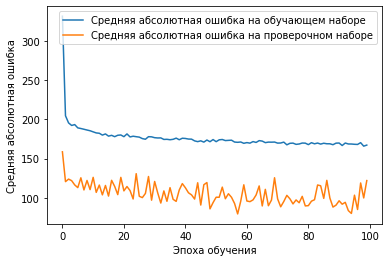

In [ ]:
model_final.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = model_final.fit([OH_X_train, model_processed_train], 
                           y_train,
                           batch_size=256, 
                           epochs=100, 
                           validation_split=0.15,
                           verbose=1)

plot_history(history)

Средняя абсолютная ошибка: 117.37459805632406 

Реальное значение: 550.00 Предсказанное значение: 412.67 Разница: 137.33
Реальное значение: 283.30 Предсказанное значение: 219.40 Разница:  63.89
Реальное значение: 510.00 Предсказанное значение: 429.64 Разница:  80.36
Реальное значение: 290.00 Предсказанное значение: 216.87 Разница:  73.13
Реальное значение: 330.00 Предсказанное значение: 280.68 Разница:  49.32
Реальное значение: 200.00 Предсказанное значение: 138.13 Разница:  61.87
Реальное значение: 490.00 Предсказанное значение: 408.36 Разница:  81.64
Реальное значение: 300.00 Предсказанное значение: 220.67 Разница:  79.33
Реальное значение: 449.00 Предсказанное значение: 364.29 Разница:  84.71
Реальное значение: 260.00 Предсказанное значение: 189.61 Разница:  70.39


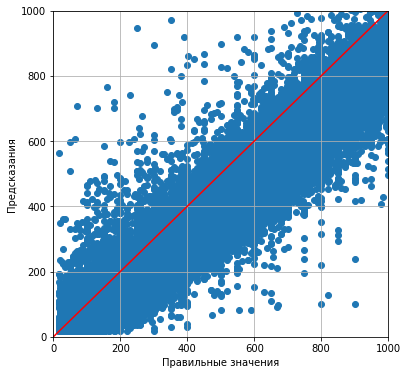

In [ ]:
eval_net(model_final, [OH_X_train, model_processed_train], y_train)

## Second model process all variables at once

In [ ]:
# add suffix to columns names to keep them unique after the concatenation 
OH_X_train = OH_X_train.add_suffix('_first')

# # Add bag of the word to the initial df
OH_X_train = pd.concat([OH_X_train.reset_index(),
                        pd.DataFrame(model_processed_train)], axis=1)

Epoch 1/50
187/187 [==============================] - 5s 24ms/step - loss: 456293.2812 - mae: 394.5261 - val_loss: 477096.2500 - val_mae: 372.2488
Epoch 2/50
187/187 [==============================] - 4s 22ms/step - loss: 445495.6250 - mae: 384.9677 - val_loss: 470385.8125 - val_mae: 382.7751
Epoch 3/50
187/187 [==============================] - 4s 22ms/step - loss: 445662.2812 - mae: 384.7856 - val_loss: 472629.0938 - val_mae: 373.9150
Epoch 4/50
187/187 [==============================] - 4s 22ms/step - loss: 443658.6250 - mae: 383.1697 - val_loss: 473438.9375 - val_mae: 371.1058
Epoch 5/50
187/187 [==============================] - 4s 22ms/step - loss: 443094.0312 - mae: 382.7713 - val_loss: 470291.1250 - val_mae: 370.2326
Epoch 6/50
187/187 [==============================] - 4s 22ms/step - loss: 442099.4062 - mae: 382.1010 - val_loss: 468553.9688 - val_mae: 380.1360
Epoch 7/50
187/187 [==============================] - 4s 22ms/step - loss: 441691.7500 - mae: 382.0354 - val_loss: 469

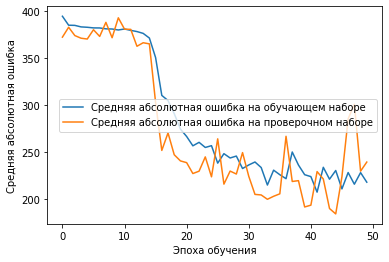

In [ ]:
# Обучение модели на простых данных
model_prof = Sequential()
model_prof.add(Dense(20, activation='relu', input_dim=OH_X_train.shape[1]))
model_prof.add(Dense(500, activation='relu'))
model_prof.add(Dropout(0.3))
model_prof.add(Dense(750, activation='relu'))
model_prof.add(Dense(1, activation='linear'))

model_prof.compile(optimizer=Adam(learning_rate=0.0007),
                   loss='mse',
                   metrics=['mae'])

history = model_prof.fit(OH_X_train, 
                    y_train, 
                    batch_size=256,
                    epochs=50, 
                    validation_split=0.15, 
                    verbose=1)

plot_history(history)

Средняя абсолютная ошибка: 235.0123692264771 

Реальное значение: 550.00 Предсказанное значение: 426.96 Разница: 123.04
Реальное значение: 283.30 Предсказанное значение: 125.46 Разница: 157.83
Реальное значение: 510.00 Предсказанное значение: 830.32 Разница: 320.32
Реальное значение: 290.00 Предсказанное значение: 516.38 Разница: 226.38
Реальное значение: 330.00 Предсказанное значение: 387.20 Разница:  57.20
Реальное значение: 200.00 Предсказанное значение: 484.57 Разница: 284.57
Реальное значение: 490.00 Предсказанное значение: 631.47 Разница: 141.47
Реальное значение: 300.00 Предсказанное значение: 407.78 Разница: 107.78
Реальное значение: 449.00 Предсказанное значение: 801.75 Разница: 352.75
Реальное значение: 260.00 Предсказанное значение: 230.63 Разница:  29.37


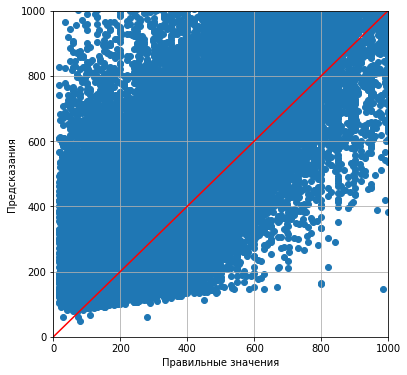

In [ ]:
eval_net(model_prof, OH_X_train, y_train)